In [1]:
import torch
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
import os

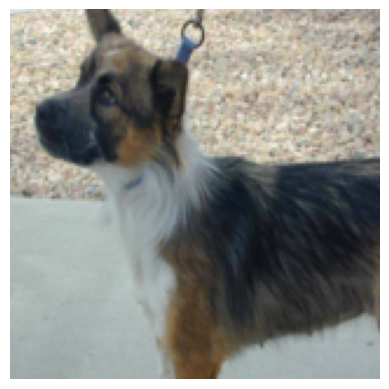

In [2]:
# MS COCO (Microsoft Common Objects in Context)
image_path = 'train/dog.3.jpg' 
image = Image.open(image_path)

# Define the transformation: resize the image and convert it to a tensor
transform = transforms.Compose([
    transforms.Resize((158, 158)),   # Resize the image to 158x158
    transforms.ToTensor()            # Convert the image to a tensor
])

# If the image is not in RGB mode, convert it to RGB
if image.mode != 'RGB':
    image = image.convert('RGB')

# Apply the transformation
image_tensor = transform(image)

# Convert the tensor back to a numpy array for displaying
image_array = image_tensor.permute(1, 2, 0).numpy()

# Display the resized image
plt.imshow(image_array)
plt.axis('off')
plt.show()


In [3]:
import os
import torch
from torchvision import transforms
from PIL import Image

dogs_num = 1000
cats_num = 1000
image_size = (158, 158)
train_dir = 'train'
validation_split = 0.2

# Check if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to load and process images
def load_image(image_path):
    image = Image.open(image_path)
    transform = transforms.Compose([
        transforms.Resize(image_size),  # Resize the image
        transforms.ToTensor()           # Convert the image to a tensor
    ])
    if image.mode != 'RGB':
        image = image.convert('RGB')
    image_tensor = transform(image).to(device)
    # Permute to (H, W, C) format
    image_tensor = image_tensor.permute(1, 2, 0)
    return image_tensor

# Function to create dataset
def create_dataset(dir_path, dogs_num, cats_num):
    data = []
    labels = []
    
    for i in range(dogs_num):
        image_path = os.path.join(dir_path, f'dog.{i}.jpg')
        image_tensor = load_image(image_path)
        label = torch.tensor([1, 0], dtype=torch.float32).to(device)  # Dog label
        data.append((image_tensor, label))
        
    for i in range(cats_num):
        image_path = os.path.join(dir_path, f'cat.{i}.jpg')
        image_tensor = load_image(image_path)
        label = torch.tensor([0, 1], dtype=torch.float32).to(device)  # Cat label
        data.append((image_tensor, label))
    
    return data

# Load training data
train_data = create_dataset(train_dir, dogs_num, cats_num)

# Shuffle data
random_order = torch.randperm(len(train_data)).tolist()
train_data = [train_data[i] for i in random_order]

# Manually split into training and validation sets
split_index = int(len(train_data) * (1 - validation_split))
train_set = train_data[:split_index]
val_set = train_data[split_index:]

# Example of accessing data
print(f'Training set size: {len(train_set)}')
print(f'Validation set size: {len(val_set)}')

# Example: Access an image and label from the training set
example_image, example_label = train_set[0]
print(f'Example image shape: {example_image.shape}')
print(f'Example label: {example_label}')


Training set size: 1600
Validation set size: 400
Example image shape: torch.Size([158, 158, 3])
Example label: tensor([0., 1.])


torch.Size([158, 158, 3])


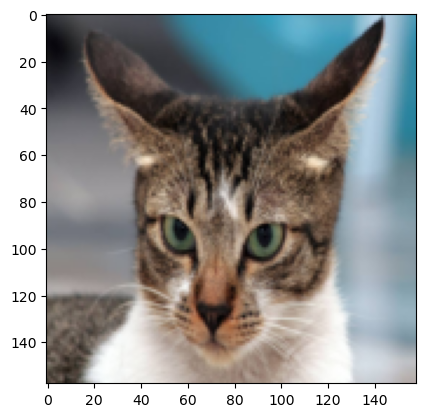

In [4]:
plt.imshow(train_set[0][0])
print(train_set[0][0].shape)

In [36]:
# Setting up functions in forward propagation
# We will forward propagate one piece of data at a time, then average over the examples, to simulate batches
def batch_norm_forward(x, gamma, beta, eps=1e-5):
    mean = torch.mean(x, dim=0)
    variance = torch.var(x, dim=0) # std_dev ** 2
    x_normalized = (x - mean) / torch.sqrt(variance + eps)
    # gamma and beta are learned
    out = gamma * x_normalized + beta
    cache = (x, x_normalized, mean, variance, gamma, beta, eps)
    return out, cache


def batch_norm_backward(dout, cache):
    x, x_normalized, mean, variance, gamma, beta, eps = cache
    N = x.shape[0]
    
    dbeta = torch.sum(dout, dim=0)
    dgamma = torch.sum(dout * x_normalized, dim=0)
    
    dx_normalized = dout * gamma
    dvariance = torch.sum(dx_normalized * (x - mean) * -0.5 * torch.pow(variance + eps, -1.5), dim=0)
    dmean = torch.sum(dx_normalized * -1 / torch.sqrt(variance + eps), dim=0) + dvariance * torch.sum(-2 * (x - mean), dim=0) / N
    
    dx = dx_normalized / torch.sqrt(variance + eps) + dvariance * 2 * (x - mean) / N + dmean / N
    return dx, dgamma, dbeta



def max_pooling(input_data, output_data):
    input_height, input_width, input_depth = input_data.shape

    # Calculate the output dimensions
    output_height = input_height // 2 
    output_width = input_width // 2
    output_depth = input_depth

    # Initialize the output tensor and tensor to store indices
    output_data = torch.zeros((output_height, output_width, output_depth))
    indices = torch.zeros((output_height, output_width, output_depth, 2), dtype=torch.int)

    # Apply max pooling
    for h in range(output_height):
        for w in range(output_width):
            for d in range(output_depth):
                # Extract the 2x2 region of interest from the input data
                region = input_data[h*2:(h+1)*2, w*2:(w+1)*2, d]
                # Compute the maximum value in the region
                max_val, max_idx = torch.max(region.reshape(-1), dim=0)
                output_data[h, w, d] = max_val
                # Find the indices of the maximum value in the region
                max_row = max_idx // 2  # Convert flattened index to row index
                max_col = max_idx % 2  # Convert flattened index to column index
                # Convert local region indices to global indices
                max_indices = torch.tensor([h * 2 + max_row, w * 2 + max_col])
                # Store the indices
                indices[h, w, d] = max_indices

    return output_data, indices



def correlate(input_image, kernel):
    # Dimensions of the input and kernel
    input_height, input_width, input_channels = input_image.shape
    filter_height, filter_width, filter_channels, num_filters = kernel.shape
    
    # Output dimensions
    output_height = input_height - filter_height + 1 # (H - S + 1)
    output_width = input_width - filter_width + 1 # (W - S + 1)

    # Initialize the output
    output = torch.zeros((output_height, output_width, num_filters))
    
    # Loop through each filter
    for filter in range(num_filters):
        # Loop through height and width of the output
        for i in range(output_height):
            for j in range(output_width):
                # Extract the patch from the input image
                input_patch = input_image[i:i+filter_height, j:j+filter_width, :]
                # Perform the correlation operation
                output[i, j, filter] = torch.sum(input_patch * kernel[:, :, :, filter]) 
    return output
    

def convolve(input_image, kernel):
    # Convert input image and kernel to torch tensors if they are not already
    if not isinstance(input_image, torch.Tensor):
        input_image = torch.tensor(input_image)
    if not isinstance(kernel, torch.Tensor):
        kernel = torch.tensor(kernel)
    
    # Dimensions of the input and kernel
    input_height, input_width, input_channels = input_image.shape
    filter_height, filter_width, filter_channels, num_filters = kernel.shape
    
    # Padding size
    pad_height = filter_height - 1
    pad_width = filter_width - 1
    
    # Output dimensions
    output_height = input_height + pad_height
    output_width = input_width + pad_width

    # Initialize the output
    output = torch.zeros((output_height, output_width, num_filters))
    
    # Pad the input image with zeros
    padded_input = torch.nn.functional.pad(input_image, (0, 0, pad_width, pad_width, pad_height, pad_height), mode='constant', value=0)
    
    # Flip kernel horizontally and vertically
    rotated_kernel = torch.flip(kernel, dims=[0, 1])
    
    # Loop through each filter
    for filter in range(num_filters):
        # Loop through the height and width of the output
        for i in range(output_height):
            for j in range(output_width):
                # Extract the patch from the padded input image
                input_patch = padded_input[i:i+filter_height, j:j+filter_width, :]
                # Perform the convolution operation
                output[i, j, filter] = torch.sum(input_patch * rotated_kernel[:, :, :, filter])
    
    return output



def der_ReLU(Z):
  return Z > 0

# def ReLU2(Z, alpha=0.01):
#     return torch.where(Z > 0, Z, alpha * Z)

def ReLU(Z): # Takes in a scalar, returns a scalar
    return torch.max(Z, torch.tensor(0.0))

# def ReLU2(Z): # Takes in a scalar, returns a scalar
#     return torch.maximum(Z, 0)

def sigmoid_prime(z):
  return sigmoid(z)*(1-sigmoid(z))

def sigmoid(z):
    # Compute the sigmoid function element-wise
    return 1.0 / (1.0 + torch.exp(-z))

def softmax(Z):
    # Compute the maximum value along the second axis (axis=1)
    max_Z = torch.max(Z, dim=1, keepdim=True).values
    # Compute the exponential of Z shifted by the maximum value
    exp_Z = torch.exp(Z - max_Z)
    # Compute the sum of the exponential values along the second axis
    sum_exp_Z = torch.sum(exp_Z, dim=1, keepdim=True)
    # Compute the softmax probabilities by dividing each exponential value by the sum
    softmax_output = exp_Z / sum_exp_Z
    return softmax_output


In [10]:
# Check if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define parameters
# Convolutional layer -> ReLU activation -> Batch normalization -> Dropout -> Max pooling

# Layer 1
# Input (158, 158, 3)
conv1_kernel = torch.randn(3, 3, 3, 32, device=device)
conv1_bias = torch.zeros(32, device=device)
layer1_output = torch.zeros(156, 156, 32, device=device)

gamma1_conv = torch.ones(32, device=device)
beta1_conv = torch.zeros(32, device=device)

layer1_pool = torch.zeros(78, 78, 32, device=device)

# Layer 2
conv2_kernel = torch.randn(3, 3, 32, 64, device=device)
conv2_bias = torch.zeros(64, device=device)
layer2_output = torch.zeros(76, 76, 64, device=device)

gamma2_conv = torch.ones(64, device=device)
beta2_conv = torch.zeros(64, device=device)

layer2_pool = torch.zeros(38, 38, 64, device=device)

# Layer 3
conv3_kernel = torch.randn(3, 3, 64, 128, device=device)
conv3_bias = torch.zeros(128, device=device)
layer3_output = torch.zeros(36, 36, 128, device=device)

gamma3_conv = torch.ones(128, device=device)
beta3_conv = torch.zeros(128, device=device)

layer3_pool = torch.zeros(18, 18, 128, device=device)

# Layer 6
fc1_weights = torch.randn(41472, 4096, device=device)
fc1_bias = torch.zeros(4096, device=device)
layer4_1_output = torch.zeros(1, 4096, device=device)

fc2_weights = torch.randn(4096, 2, device=device)
fc2_bias = torch.zeros(2, device=device)
layer4_2_output = torch.zeros(1, 2, device=device)


In [11]:
# Forward propagation
# Convolutional layer -> ReLU activation -> Batch normalization -> Dropout -> Max pooling
def forward_propagation(
    layer_input, conv1_kernel, conv1_bias, layer1_output, gamma1_conv, beta1_conv, layer1_pool,
    conv2_kernel, conv2_bias, layer2_output, gamma2_conv, beta2_conv, layer2_pool,
    conv3_kernel, conv3_bias, layer3_output, gamma3_conv, beta3_conv, layer3_pool,
    fc1_weights, fc1_bias, layer6_1_output, fc2_weights, fc2_bias, layer6_2_output, dropout_rate=0.25):

    print("forward prop")
    
    # Layer 1
    layer1_output = correlate(layer_input, conv1_kernel)
    layer1_output += conv1_bias
    layer1_output = ReLU(layer1_output)

    layer1_output, layer1_cache = batch_norm_forward(layer1_output, gamma1_conv, beta1_conv)
    
    dropout1_mask = (torch.rand_like(layer1_output) < dropout_rate).float() / dropout_rate
    layer1_output *= dropout1_mask

    layer1_pool, layer1_indices = max_pooling(layer1_output, layer1_pool)

    # Layer 2
    layer2_output = correlate(layer1_pool, conv2_kernel)
    layer2_output += conv2_bias
    layer2_output = ReLU(layer2_output)

    layer2_output, layer2_cache = batch_norm_forward(layer2_output, gamma2_conv, beta2_conv)
    
    dropout2_mask = (torch.rand_like(layer2_output) < dropout_rate).float() / dropout_rate
    layer2_output *= dropout2_mask

    layer2_pool, layer2_indices = max_pooling(layer2_output, layer2_pool)

    # Layer 3
    layer3_output = correlate(layer2_pool, conv3_kernel)
    layer3_output += conv3_bias
    layer3_output = ReLU(layer3_output)

    layer3_output, layer3_cache = batch_norm_forward(layer3_output, gamma3_conv, beta3_conv)
    
    dropout3_mask = (torch.rand_like(layer3_output) < dropout_rate).float() / dropout_rate
    layer3_output *= dropout3_mask

    layer3_pool, layer3_indices = max_pooling(layer3_output, layer3_pool)
        
    # Layer 4
    layer4_1_output = layer3_pool.view(-1, 41472) @ fc1_weights
    layer4_1_output += fc1_bias
    layer4_1_output = ReLU(layer4_1_output)
    
    layer4_2_output = layer4_1_output @ fc2_weights
    layer4_2_output += fc2_bias
    
    layer4_2_output = softmax(layer4_2_output)
    
    return (layer1_indices, layer1_cache, dropout1_mask, layer2_indices, layer2_cache, dropout2_mask, layer3_indices, layer3_cache, dropout3_mask)


In [26]:
# Backpropagation
# dog = 0, cat = 1. Define first option as dog, second as cat. Can only be [0,1] or [1,0]
# As a tuple, define one training example as a (numpy_array, [1,0]..) tuple
def backward_pass(layer_input, label, layer1_indices, layer1_cache, dropout1_mask, layer2_indices, layer2_cache, dropout2_mask, layer3_indices, layer3_cache, dropout3_mask):
    
    print("backward pass")
    
    dlayer3_pool = torch.zeros_like(layer3_pool)
    dconv3_kernel = torch.zeros_like(conv3_kernel)
    dlayer3_output = torch.zeros_like(layer3_output)
    
    dlayer2_pool = torch.zeros_like(layer2_pool)
    dconv2_kernel = torch.zeros_like(conv2_kernel)
    dlayer2_output = torch.zeros_like(layer2_output)

    dlayer1_pool = torch.zeros_like(layer1_pool)
    dconv1_kernel = torch.zeros_like(conv1_kernel)
    dlayer1_output = torch.zeros_like(layer1_output)

    ### Layer 4 ----------------------------------------------------------------------------------------------------------------------------------------
    
    # Softmax
    dlayer4_2_output = layer4_2_output - label  # (1,2)
    
    # fc2
    dfc2_bias = dlayer4_2_output  # (1,2)
    
    dfc2_weights = torch.matmul(layer4_1_output.T, dlayer4_2_output)  # (4096,1) @ (1,2) = (4096,2)
    
    dlayer4_1_output = torch.matmul(dlayer4_2_output, fc2_weights.T) * der_ReLU(layer4_1_output) 
    
    # fc1
    dfc1_bias = dlayer4_1_output
    
    dfc1_weights = torch.matmul(layer3_pool.view(1, 41472).T, dlayer4_1_output)
    
    dlayer3_pool = torch.matmul(dlayer4_1_output, fc1_weights.T)


    ### Layer 3 ----------------------------------------------------------------------------------------------------------------------------------------

    # Unflatten
    dlayer3_pool = dlayer3_pool.view(18, 18, 128)
    
    # Unpooling
    for i in range(dlayer3_pool.shape[0]):
        for j in range(dlayer3_pool.shape[1]): 
            for k in range(dlayer3_pool.shape[2]):
                # Get the global indices from layer_indices
                x_index, y_index = layer3_indices[i, j, k]  # -> (18, 18, 512, 2)
                # Assign the gradient from dZ_pool_output to the corresponding position in dZ_pool_input
                dlayer3_output[x_index, y_index, k] = dlayer3_pool[i, j, k]
    
    # Dropout
    dlayer3_output *= dropout3_mask

    # Batch norm
    dlayer3_output, dgamma3_conv, dbeta3_conv = batch_norm_backward(dlayer3_output, layer3_cache)

    # BP conv
    dlayer3_output *= der_ReLU(layer3_output)
    dconv3_bias = dlayer3_output

    # Looping over filters
    for filter in range(conv3_kernel.shape[3]): 
        temp2 = dlayer3_output[:, :, filter].view(dlayer3_output.shape[0], dlayer3_output.shape[0], 1, 1)
        for slice in range(conv3_kernel.shape[2]):
            temp1 = layer2_pool[:, :, slice].view(layer2_pool.shape[0], layer2_pool.shape[0], 1)
            dconv3_kernel[:, :, slice, filter] = correlate(temp1, temp2).view(3, 3)

    for filter in range(conv3_kernel.shape[3]): 
        temp1 = dlayer3_output[:, :, filter].view(dlayer3_output.shape[0], dlayer3_output.shape[0], 1)
        for slice in range(conv3_kernel.shape[2]):
            temp2 = conv3_kernel[:, :, slice, filter].view(3, 3, 1, 1)
            dlayer2_pool += convolve(temp1, temp2)

    ### Layer 2 ----------------------------------------------------------------------------------------------------------------------------------------
    # Unpooling 
    for i in range(dlayer2_pool.shape[0]):
        for j in range(dlayer2_pool.shape[1]): 
            for k in range(dlayer2_pool.shape[2]):
                # Get the global indices from layer_indices
                x_index, y_index = layer2_indices[i, j, k]  # -> (18, 18, 512, 2)
                # Assign the gradient from dZ_pool_output to the corresponding position in dZ_pool_input
                dlayer2_output[x_index, y_index, k] = dlayer2_pool[i, j, k]
    
    # Layer 2 - Dropout
    dlayer2_output *= dropout2_mask

    # Layer 2 - Batch norm
    dlayer2_output, dgamma2_conv, dbeta2_conv = batch_norm_backward(dlayer2_output, layer2_cache)

    # Layer 2 - BP conv
    dlayer2_output *= der_ReLU(layer2_output)
    dconv2_bias = dlayer2_output

    # Looping over filters
    for filter in range(conv2_kernel.shape[3]):  # 128
        temp2 = dlayer2_output[:, :, filter].view(dlayer2_output.shape[0], dlayer2_output.shape[0], 1, 1)
        for slice in range(conv2_kernel.shape[2]):  # 128
            temp1 = layer1_pool[:, :, slice].view(layer1_pool.shape[0], layer1_pool.shape[0], 1)
            dconv2_kernel[:, :, slice, filter] = correlate(temp1, temp2).view(3, 3)

    for filter in range(conv2_kernel.shape[3]): 
        temp1 = dlayer2_output[:, :, filter].view(dlayer2_output.shape[0], dlayer2_output.shape[0], 1)
        for slice in range(conv2_kernel.shape[2]): 
            temp2 = conv2_kernel[:, :, slice, filter].view(3, 3, 1, 1)
            dlayer1_pool += convolve(temp1, temp2)
    

    ### Layer 1 ----------------------------------------------------------------------------------------------------------------------------------------
    
    # Unpooling
    for i in range(dlayer1_pool.shape[0]):
        for j in range(dlayer1_pool.shape[1]): 
            for k in range(dlayer1_pool.shape[2]):
                # Get the global indices from layer_indices
                x_index, y_index = layer1_indices[i, j, k]  # -> (18, 18, 512, 2)
                # Assign the gradient from dZ_pool_output to the corresponding position in dZ_pool_input
                dlayer1_output[x_index, y_index, k] = dlayer1_pool[i, j, k]
    
    # Layer 1 - Dropout
    dlayer1_output *= dropout1_mask
    
    # Layer 1 - Batch norm
    dlayer1_output, dgamma1_conv, dbeta1_conv = batch_norm_backward(dlayer1_output, layer1_cache)

    # Layer 1 - BP conv2
    dlayer1_output *= der_ReLU(layer1_output)  # (144,144,64)
    dconv1_bias = dlayer1_output  # (144,144,64)

    # Looping over filters
    for filter in range(conv1_kernel.shape[3]):  # 64
        temp2 = dlayer1_output[:, :, filter].view(dlayer1_output.shape[0], dlayer1_output.shape[0], 1, 1)
        for slice in range(layer_input.shape[2]):  # 3
            temp1 = layer_input[:, :, slice].view(layer_input.shape[0], layer_input.shape[0], 1)
            dconv1_kernel[:, :, slice, filter] = correlate(temp1, temp2).view(3, 3)

    return (dconv1_kernel, dconv1_bias, dgamma1_conv, dbeta1_conv,
            dconv2_kernel, dconv2_bias, dgamma2_conv, dbeta2_conv, 
            dconv3_kernel, dconv3_bias, dgamma3_conv, dbeta3_conv,
            dfc1_weights, dfc1_bias, dfc2_weights, dfc2_bias)

In [27]:
def update_params(
    dconv1_kernel, dconv1_bias, dgamma1_conv, dbeta1_conv,
    dconv2_kernel, dconv2_bias, dgamma2_conv, dbeta2_conv, 
    dconv3_kernel, dconv3_bias, dgamma3_conv, dbeta3_conv,
    dfc1_weights, dfc1_bias, dfc2_weights, dfc2_bias,
    learning_rate
):
    global conv1_kernel, conv1_bias, gamma1_conv, beta1_conv
    global conv2_kernel, conv2_bias, gamma2_conv, beta2_conv
    global conv3_kernel, conv3_bias, gamma3_conv, beta3_conv
    global fc1_weights, fc1_bias, fc2_weights, fc2_bias

    print("updating")
    
    conv1_kernel -= learning_rate * dconv1_kernel
    conv1_bias -= learning_rate * dconv1_bias
    gamma1_conv -= learning_rate * dgamma1_conv
    beta1_conv -= learning_rate * dbeta1_conv

    conv2_kernel -= learning_rate * dconv2_kernel
    conv2_bias -= learning_rate * dconv2_bias
    gamma2_conv -= learning_rate * dgamma2_conv
    beta2_conv -= learning_rate * dbeta2_conv

    conv3_kernel -= learning_rate * dconv3_kernel
    conv3_bias -= learning_rate * dconv3_bias
    gamma3_conv -= learning_rate * dgamma3_conv
    beta3_conv -= learning_rate * dbeta3_conv

    fc1_weights -= learning_rate * dfc1_weights
    fc1_bias -= learning_rate * dfc1_bias
    fc2_weights -= learning_rate * dfc2_weights
    fc2_bias -= learning_rate * dfc2_bias

In [14]:
def get_prediction(output):
    return torch.argmax(output, axis=1)

In [28]:
def stochastic_gradient_descent(train_set, val_set, epochs, learning_rate, batch_size):
    num_examples = len(train_set)

    # Looping over epochs
    for epoch in range(epochs):
        print("Epoch:", epoch + 1)

        # Looping over batches
        for batch_start in range(0, num_examples, batch_size):
            batch_end = min(batch_start + batch_size, num_examples)
            
            # Initialize batch_gradients to accumulate gradients
            batch_gradients = [
                torch.zeros_like(conv1_kernel), torch.zeros_like(conv1_bias),
                torch.zeros_like(gamma1_conv), torch.zeros_like(beta1_conv),
                
                torch.zeros_like(conv2_kernel), torch.zeros_like(conv2_bias),
                torch.zeros_like(gamma2_conv), torch.zeros_like(beta2_conv),
                
                torch.zeros_like(conv3_kernel), torch.zeros_like(conv3_bias),
                torch.zeros_like(gamma3_conv), torch.zeros_like(beta3_conv),
                
                torch.zeros_like(fc1_weights), torch.zeros_like(fc1_bias),
                torch.zeros_like(fc2_weights), torch.zeros_like(fc2_bias)
            ]
            
            # Loop over a single batch
            for _ in range(batch_start, batch_end):
                # Get a single training example
                random_idx = torch.randint(len(train_set), (1,)).item()
                layer_input, label = train_set[random_idx]
                
                # Forward propagation
                (layer1_indices, layer1_cache, dropout1_mask, layer2_indices, layer2_cache, dropout2_mask, layer3_indices, layer3_cache, dropout3_mask) = forward_propagation(layer_input, conv1_kernel, conv1_bias, layer1_output, gamma1_conv, beta1_conv, layer1_pool,
                conv2_kernel, conv2_bias, layer2_output, gamma2_conv, beta2_conv, layer2_pool,
                conv3_kernel, conv3_bias, layer3_output, gamma3_conv, beta3_conv, layer3_pool,
                fc1_weights, fc1_bias, layer4_1_output, fc2_weights, fc2_bias, layer4_2_output, 0.25)
                
                # Back propagation
                gradients = backward_pass(layer_input, label, layer1_indices, layer1_cache, dropout1_mask, layer2_indices, layer2_cache, dropout2_mask, layer3_indices, layer3_cache, dropout3_mask)
                
                # Accumulate gradients
                for k in range(len(batch_gradients)):
                    batch_gradients[k] += gradients[k]
            
            # Average gradients after processing the batch
            batch_gradients = [grad / batch_size for grad in batch_gradients]
            
            # Update parameters after processing the batch
            update_params(*batch_gradients, learning_rate)

        print("predicting")
        
        # Get training accuracy
        train_accuracy = 0
        for _ in range(100):
            random_idx = torch.randint(len(train_set), (1,)).item()
            test_input, true_label = train_set[random_idx]
            (layer1_indices, layer1_cache, dropout1_mask, layer2_indices, layer2_cache, dropout2_mask, layer3_indices, layer3_cache, dropout3_mask) = forward_propagation(test_input, conv1_kernel, conv1_bias, layer1_output, gamma1_conv, beta1_conv, layer1_pool,
            conv2_kernel, conv2_bias, layer2_output, gamma2_conv, beta2_conv, layer2_pool,
            conv3_kernel, conv3_bias, layer3_output, gamma3_conv, beta3_conv, layer3_pool,
            fc1_weights, fc1_bias, layer4_1_output, fc2_weights, fc2_bias, layer4_2_output, 0.25)
            prediction = get_prediction(layer4_2_output)
            if torch.argmax(true_label) == torch.argmax(prediction):
                train_accuracy += 1
        print("Training Accuracy:", train_accuracy / 100)
        
        # Get validation accuracy
        val_accuracy = 0
        for _ in range(100):
            random_idx = torch.randint(len(val_set), (1,)).item()
            test_input, true_label = val_set[random_idx]
            (layer1_indices, layer1_cache, dropout1_mask, layer2_indices, layer2_cache, dropout2_mask, layer3_indices, layer3_cache, dropout3_mask) = forward_propagation(test_input, conv1_kernel, conv1_bias, layer1_output, gamma1_conv, beta1_conv, layer1_pool,
            conv2_kernel, conv2_bias, layer2_output, gamma2_conv, beta2_conv, layer2_pool,
            conv3_kernel, conv3_bias, layer3_output, gamma3_conv, beta3_conv, layer3_pool,
            fc1_weights, fc1_bias, layer4_1_output, fc2_weights, fc2_bias, layer4_2_output, 0.25)
            prediction = get_prediction(layer4_2_output)
            if torch.argmax(true_label) == torch.argmax(prediction):
                val_accuracy += 1
        print("Validation Accuracy:", val_accuracy / 100)

In [37]:
learning_rate = 0.1
batch_size = 32
epochs = 10
stochastic_gradient_descent(train_set, val_set, epochs, learning_rate, batch_size)

Epoch: 1
forward prop
backward pass


KeyboardInterrupt: 

In [ ]:
# Define the parameters dictionary
params = {
    # Layer 1
    'conv1_kernel': conv1_kernel,
    'conv1_bias': conv1_bias,
    'gamma1_conv': gamma1_conv,
    'beta1_conv': beta1_conv,
    
    # Layer 2
    'conv2_kernel': conv2_kernel,
    'conv2_bias': conv2_bias,
    'gamma2_conv': gamma2_conv,
    'beta2_conv': beta2_conv,

    # Layer 3
    'conv3_kernel': conv3_kernel,
    'conv3_bias': conv3_bias,
    'gamma3_conv': gamma3_conv,
    'beta3_conv': beta3_conv,

    # Layer 4
    'fc1_weights': fc1_weights,
    'fc1_bias': fc1_bias,
    'fc2_weights': fc2_weights,
    'fc2_bias': fc2_bias
}

# Save the parameters to a file using torch.save
torch.save(params, 'model_parameters.pth')

# To load the parameters, use the following code:
# loaded_params = torch.load('model_parameters.pth')
# Example of accessing loaded parameters:
# conv1_kernel_loaded = loaded_params['conv1_kernel']